![for sale image, from https://time.com/5835778/selling-home-coronavirus/](https://api.time.com/wp-content/uploads/2020/05/selling-home-coronavirus.jpg?w=800&quality=85)

# Project Title

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

Questions to consider:

- Need to fill this out
- Who are your stakeholders?
- What are your stakeholders' pain points related to this project?
- Why are your predictions important from a business perspective?

## Data Understanding

Describe the data being used for this project.

Questions to consider:

- Where did the data come from, and how do they relate to the data analysis questions?
- What do the data represent? Who is in the sample and what variables are included?
- What is the target variable?
- What are the properties of the variables you intend to use?

### Data Understanding Summary

- The data represents ~22K home sales in Kings County, Washington from September 2014 through January 2015
- It's unclear whether this is just single family homes or if multi family / condominiums are included as well
- The data includes the sale price of the home and a number of descriptors, including many variables about size (number of rooms, square footage, lot size), location (zip code, lat / lon), and other attributes (waterfront, basement, etc).

In [1]:
# Standard imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder

# Import functions to run and evaluate regression models
from util import run_model, evaluate_model, high_corr

In [2]:
# Import data

df_sales = pd.read_csv('kc_house_data.csv')

In [3]:
df_sales['floors'].value_counts()

1.0    10673
2.0     8235
1.5     1910
3.0      611
2.5      161
3.5        7
Name: floors, dtype: int64

In [4]:
# Run info to check for general data types and nulls

df_sales.info()

# Summary: all are numbers except Date and Basement_sqft. The latter should probably be converted to a number.
# Some of the numbers are likely categorical and need to be treated as such.
# 22K entries total. Most columns do not contain nulls (will need to clean up waterfront and yr_renovated)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [5]:
# Dependent variable will be 'price'

### Numeric data exploration

In [6]:
df_num = df_sales.select_dtypes(include=['float64', 'int64'])

In [7]:
y = df_num['price']
X = df_num.drop(columns=['price','id', 'lat', 'long'], axis=1)

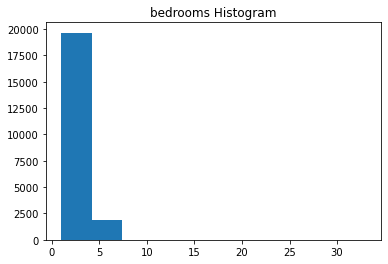

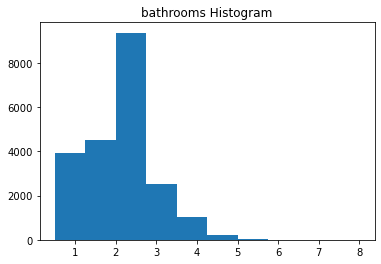

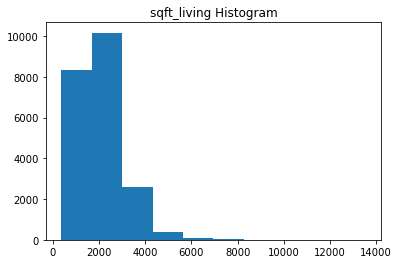

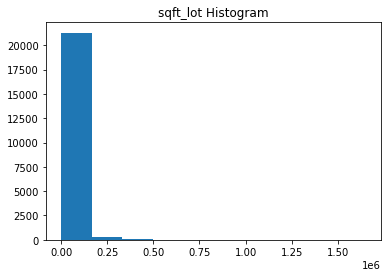

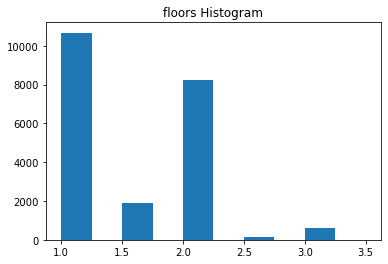

/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


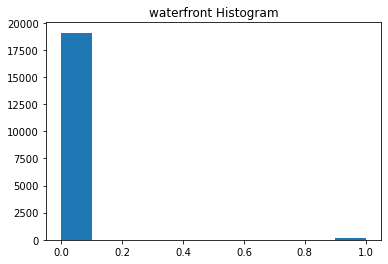

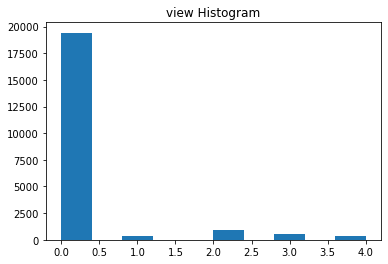

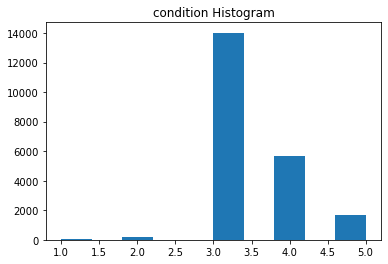

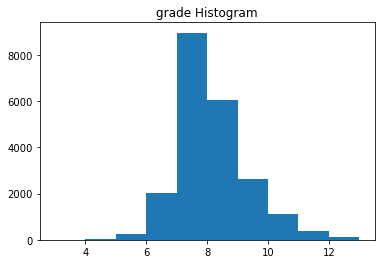

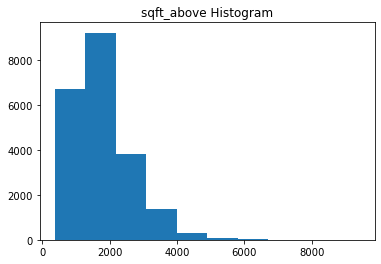

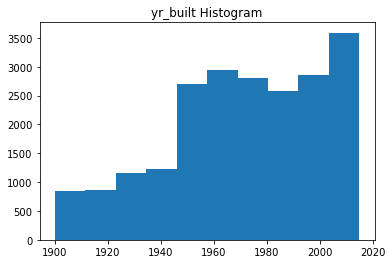

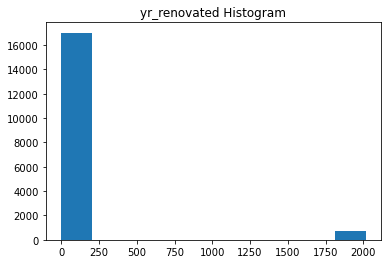

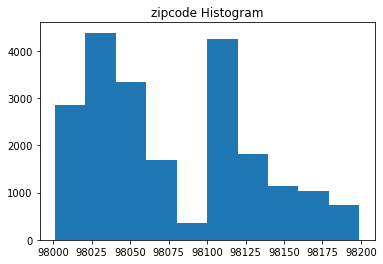

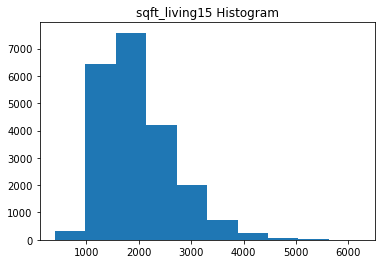

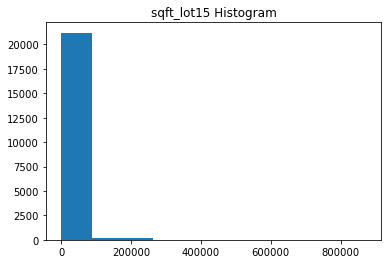

In [8]:
# Check for normality

for col in X.columns:
    plt.hist(X[col])
    plt.title(f"{col} Histogram")
    plt.show();
    
# Conclusions: 
# * Transform bedrooms and bathrooms into categorical variables
# * Log transform sqft_living to normalize it
# * Check for collinearity among the "size" metrics
# * Floors as categorical (done by Teigen)
# * Make condition a categorical by 4+ as good condition
# * Keep grade as a continuous variable


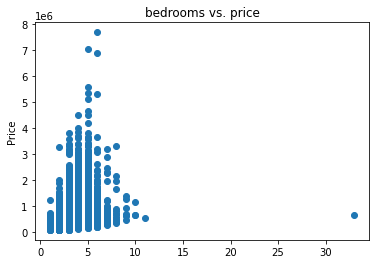

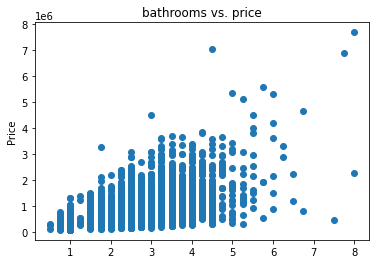

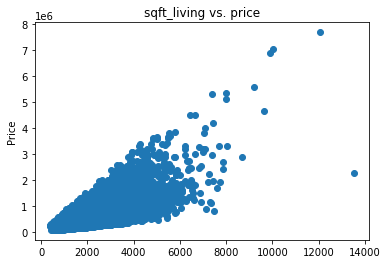

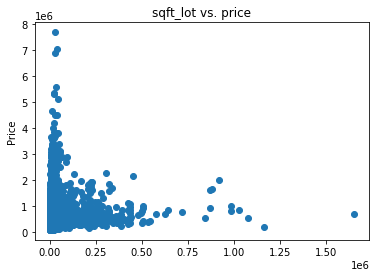

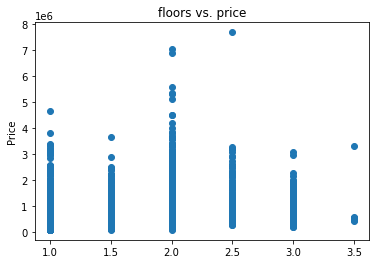

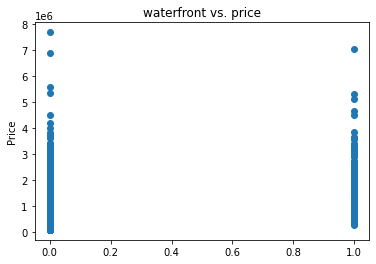

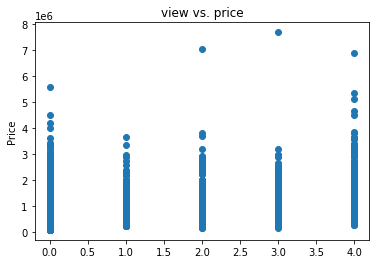

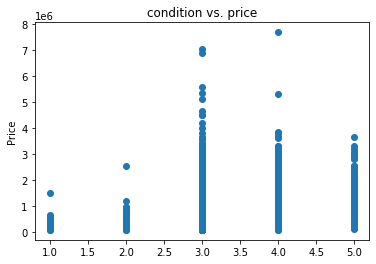

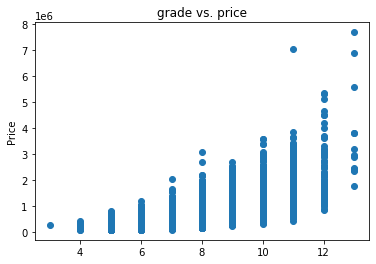

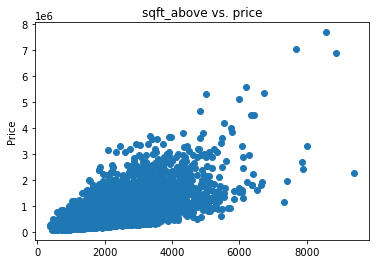

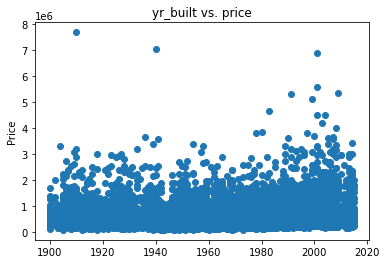

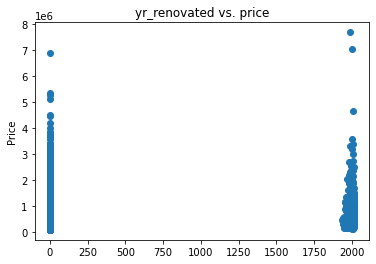

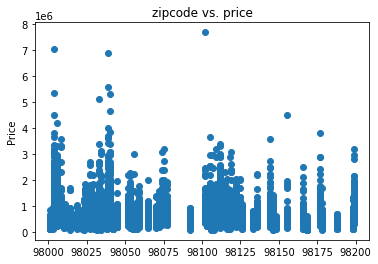

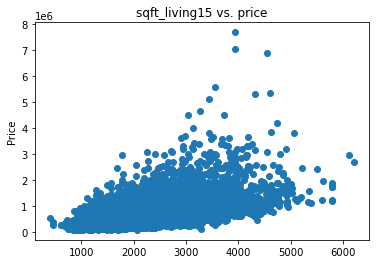

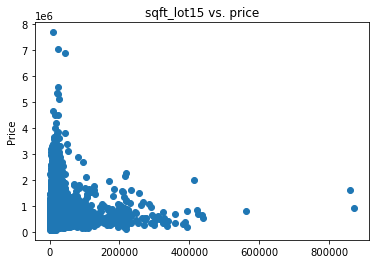

In [9]:
# Check for linear relationship between numbers and sales

for col in X.columns:
    plt.scatter(X[col], y)
    plt.title(f"{col} vs. price")
    plt.ylabel("Price")
    plt.show();

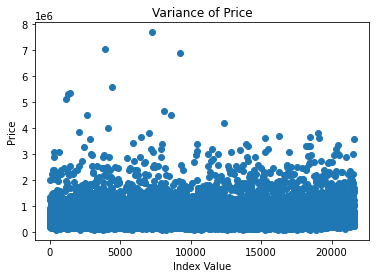

In [10]:
# also plot sales against itself
plt.scatter(y.index, y)
# plt.hlines(y.mean(), 0, 3000000)
plt.xlabel('Index Value')
plt.ylabel('Price')
plt.title('Variance of Price')
plt.show()

### Non-numeric data exploration

Covering date and sqft_basement

In [11]:
# This dataset contains home sales from September 2014 through January 2015.
# Will not likely use date in any meaningful way

latest_date = df_sales['date'].min()
earliest_date = df_sales['date'].max()

sorted_date = df_sales['date'].sort_values(ascending=False)

print(earliest_date, latest_date)

9/9/2014 1/10/2015


In [12]:
# There are 304 unique values here. 12K of them are 0. 
# Two steps:
# Converted to numerical
# Used to create a new binary categorical variable "has_basement"

print(len(df_sales['sqft_basement'].unique()))
(df_sales['sqft_basement'] == '0.0').sum()

304


12826

### Categorical variables

Exploring which fields are categorical, and how to deal with them

In [13]:
# Based column description, there are a few existing categorical variables and a few fields that we may want
# to transform into categorical variables

# Existing categorical variables
existing_cat = ['waterfront', 'view', 'zipcode']

# Fields we may want to transform into categorical variables
potential_cat = ['yr_built', 'yr_renovated', 'sqft_basement', 'floors']

# yr_built: could divide in binary variable called "recently built" to show developer new houses sell well
# sqft_basement: transform into variable showing whether there's a basement or not
# yr_renovated: transform into whether the house has been renovated or not
# floors: transform into binary variable for having multiple stories or not

### Outliers

Identifying outliers among the data

In [14]:
df_sales.describe().apply(lambda s: s.apply('{0:.0f}'.format))

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21597,21597,21597,21597,21597,21597,21597,19221,21534,21597,21597,21597,21597,17755,21597,21597,21597,21597,21597
mean,4580474288,540297,3,2,2080,15099,1,0,0,3,8,1789,1971,84,98078,48,-122,1987,12758
std,2876735716,367368,1,1,918,41413,1,0,1,1,1,828,29,400,54,0,0,685,27274
min,1000102,78000,1,0,370,520,1,0,0,1,3,370,1900,0,98001,47,-123,399,651
25%,2123049175,322000,3,2,1430,5040,1,0,0,3,7,1190,1951,0,98033,47,-122,1490,5100
50%,3904930410,450000,3,2,1910,7618,2,0,0,3,7,1560,1975,0,98065,48,-122,1840,7620
75%,7308900490,645000,4,2,2550,10685,2,0,0,4,8,2210,1997,0,98118,48,-122,2360,10083
max,9900000190,7700000,33,8,13540,1651359,4,1,4,5,13,9410,2015,2015,98199,48,-121,6210,871200


In [15]:
# There appear to be outliers in 'bedrooms', 'grade', and 'sqft_lot' based on max values

# Bedroom outlier check
bedroom_outlier = df_sales[df_sales['bedrooms'] == 33]

bedroom_outlier

# Conclusion: seems to be a typo. Filter for everything with fewer than 8 bedrooms as our developer is 
# unlikely to want to build these properties

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15856,2402100895,6/25/2014,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,...,7,1040,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700


In [16]:
df_sales['bedrooms'].value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [17]:
# Grade outlier check

df_sales['grade'].value_counts()

# Conclusion: not actually an outlier. Grades go up to 13 and indicate the quality of materials used.

7     8974
8     6065
9     2615
6     2038
10    1134
11     399
5      242
12      89
4       27
13      13
3        1
Name: grade, dtype: int64

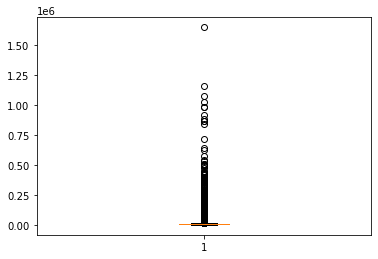

In [18]:
# Sqft_lot check

plt.boxplot(df_sales['sqft_lot']);

# Conclusion: while possible a valid entry, 1.6mm square feet converts to 38 acres.
# The developer is unlikely to consider building on property more than a few acres large.
# Can probably apply a filter of 200K square feet for lot size (~4.5 acres). This covers 99% of the dataset

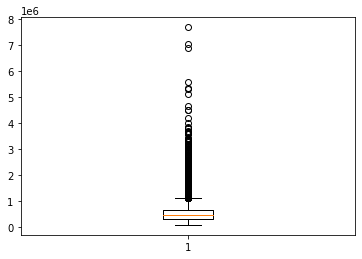

In [19]:
# Price check. Can probably filter for outerliers over 2mm. This captures 99% of the dataset but removes
# some more extreme values

plt.boxplot(df_sales['price']);

In [20]:
len(df_sales[df_sales['price'] <= 2000000]) / len(df_sales)

0.9908320600083345

In [21]:
num = 200000

len(df_sales[df_sales['sqft_lot'] < num]) / len(df_sales)

0.9880538963744965

### Null values

Determining what to do with Nulls

In [22]:
df_sales.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [23]:
# View
# Conclusion: Given the overwhelming tendency towards 0, replace the null values with 0

df_sales['view'].value_counts()

0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

In [24]:
df_sales[df_sales['waterfront'].isna()]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
10,1736800520,4/3/2015,662500.0,3,2.50,3560,9796,1.0,NaN,0.0,...,8,1860,1700.0,1965,0.0,98007,47.6007,-122.145,2210,8925
23,8091400200,5/16/2014,252700.0,2,1.50,1070,9643,1.0,NaN,0.0,...,7,1070,0.0,1985,NaN,98030,47.3533,-122.166,1220,8386
40,5547700270,7/15/2014,625000.0,4,2.50,2570,5520,2.0,NaN,0.0,...,9,2570,0.0,2000,NaN,98074,47.6145,-122.027,2470,5669
55,9822700295,5/12/2014,885000.0,4,2.50,2830,5000,2.0,NaN,0.0,...,9,2830,0.0,1995,0.0,98105,47.6597,-122.290,1950,5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21578,5087900040,10/17/2014,350000.0,4,2.75,2500,5995,2.0,NaN,0.0,...,8,2500,0.0,2008,0.0,98042,47.3749,-122.107,2530,5988
21582,8956200760,10/13/2014,541800.0,4,2.50,3118,7866,2.0,NaN,2.0,...,9,3118,0.0,2014,0.0,98001,47.2931,-122.264,2673,6500
21586,844000965,6/26/2014,224000.0,3,1.75,1500,11968,1.0,NaN,0.0,...,6,1500,0.0,2014,0.0,98010,47.3095,-122.002,1320,11303
21587,7852140040,8/25/2014,507250.0,3,2.50,2270,5536,2.0,NaN,0.0,...,8,2270,0.0,2003,0.0,98065,47.5389,-121.881,2270,5731


In [25]:
# Waterfront
# Conclusion: replace these nulls with 0 given overwhelming tendency in that direction

df_sales['waterfront'].value_counts()

0.0    19075
1.0      146
Name: waterfront, dtype: int64

In [26]:
df_sales[df_sales['yr_renovated'].isna()]['yr_built'].value_counts()

2014    102
1977     77
2003     77
2008     75
2006     73
       ... 
1902      6
1901      6
1934      5
1936      5
1904      4
Name: yr_built, Length: 116, dtype: int64

In [27]:
# yr_renovated
# Conclusion: null values here probably mean the home hasn't been renovated, replace with zero.

df_sales['yr_renovated'].value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

## Data Preparation

Describe and justify the process for preparing the data for analysis.

Questions to consider:

- Null values for views, waterfront, and yr_renovated were replaced with the most common value
- Thresholds were set to control for outliers due to either data entry errors or properties that are out of scope for our analysis
- [Were there variables you dropped or created?] TBD
- [Why are these choices appropriate given the data and the business problem?] TBD

In [28]:
sales_clean = df_sales.copy()

### Null values

- Replacing view, waterfront, and yr_renovated with their most common value

In [29]:
# Replace nulls in view, yr_renovated, and waterfront with its most common value

from sklearn.impute import SimpleImputer

columns_to_replace = ['view', 'yr_renovated', 'waterfront']

for col in columns_to_replace:
    imputer = SimpleImputer(strategy='most_frequent')
    to_impute = sales_clean[[col]]
    col_imputed = imputer.fit_transform(to_impute)
    sales_clean[col] = col_imputed

### Outliers

In [30]:
len(df_sales[df_sales['bedrooms'] <= 5]) / len(df_sales)
len(df_sales[df_sales['sqft_lot'] <= 200000]) / len(df_sales)
len(df_sales[df_sales['price'] <= 2000000]) / len(df_sales)

0.9908320600083345

In [31]:
# Set thresholds to filter dataset down for outliers

max_bedrooms = 5
max_sq_ft = 200000
max_price = 2000000

sales_clean = sales_clean[sales_clean['bedrooms'] <= max_bedrooms]
sales_clean = sales_clean[sales_clean['sqft_lot'] <= max_sq_ft]
sales_clean = sales_clean[sales_clean['price'] <= max_price]

### Create categorical variables

In [32]:
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [33]:
recent_build = 2005

# Was the house built after the year defined above (1) or not (0)
sales_clean['recent_build'] = 0
sales_clean['recent_build'].loc[sales_clean['yr_built'] >= recent_build] = 1


# Has the house been renovated (1) or not (0)
sales_clean['is_renovated'] = 0
sales_clean['is_renovated'].loc[sales_clean['yr_renovated'] != 0] = 1

# Has the house been renovated after year defined above (1) or not (0)
# Removing this because there are no recently renovated homes
# sales_clean['recent_renovation'] = 0
# sales_clean.loc[(sales_clean['is_renovated'] == 1) & (sales_clean['yr_built'] >= recent_build),
#                'recent_renovation'] = 1

In [34]:
# Add categorical for 1.5 floors or greater

floor_list = []
for i in sales_clean['floors']:
    if i > 1.0:
        floor_list.append(1)
    else:
        floor_list.append(0)
        
sales_clean['multi_story'] = floor_list

In [35]:
# Add categorical for 2 floors or greater

floor_list2 = []
for i in sales_clean['floors']:
    if i >= 2.0:
        floor_list2.append(1)
    else:
        floor_list2.append(0)
        
sales_clean['two_or_more_stories'] = floor_list2

In [36]:
# Add categorical for has a basement or not

basement_list = []
for i in sales_clean['sqft_basement']:
    if i == '0.0':
        basement_list.append(0)
    elif i == '?':
        basement_list.append(0)
    else:
        basement_list.append(1)

sales_clean['basement'] = basement_list

In [37]:
# Create bathroom / bedroom categoricals based on size

bathroom_threshold = 3
bedroom_threshold = 4

sales_clean['high_bathrooms'] = 0
sales_clean['high_bathrooms'].loc[sales_clean['bathrooms'] >= bathroom_threshold] = 1

sales_clean['high_bedrooms'] = 0
sales_clean['high_bedrooms'].loc[sales_clean['bedrooms'] >= bedroom_threshold] = 1

In [38]:
# Function for zip code categoricals

def zipcode_encoder(df):
    zipcodes = df[['zipcode']]
    ohe = OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore')
    ohe.fit(zipcodes)
    encoded_zipcodes = ohe.transform(zipcodes)
    zipcodes = list(ohe.categories_[0])
    encoded_zipcodes_df = pd.DataFrame(encoded_zipcodes, 
                                       columns=ohe.get_feature_names(['zipcode']),
                                       index = df.index)
    
    return encoded_zipcodes_df

In [39]:
# Add zip code categorical to data frame

pd.set_option('display.max_columns', None)

sales_clean =  pd.concat([sales_clean, zipcode_encoder(sales_clean)], axis=1)

In [40]:
# Append neighborhood categories

zipcode_dict = {98002: 'Auburn',98092: 'Auburn',98224: 'Baring',98004: 'Bellevue',98005: 'Bellevue',
98006: 'Bellevue',98007: 'Bellevue',98008: 'Bellevue',98010: 'Black_Diamond',98011: 'Bothell',
98178: 'Bryn_Mawr_Skyway',98148: 'Burien',98166: 'Burien',98014: 'Carnation',98077: 'Cottage_Lake',
98042: 'Covington',98198: 'Des_Moines',98019: 'Duvall',98031: 'East_Hill_Meridian',98022: 'Enumclaw',
98058: 'Fairwood',98024: 'Fall_City',98003: 'Federal_Way',98023: 'Federal_Way',98027: 'Issaquah',
98029: 'Issaquah',98028: 'Kenmore',98032: 'Kent',98030: 'Kent',98033: 'Kirkland',98034: 'Kirkland',
98001: 'Lakeland_North',98038: 'Maple_Valley',98039: 'Medina',98040: 'Mercer_Island',98045: 'North_Bend',
98047: 'Pacific',98050: 'Preston',98051: 'Ravensdale',98052: 'Redmond',98055: 'Renton',98056: 'Renton',
98057: 'Renton',98059: 'Renton',98074: 'Sammamish',98075: 'Sammamish',98188: 'SeaTac',98199: 'Seattle',
98174: 'Seattle',98154: 'Seattle',98158: 'Seattle',98164: 'Seattle',98101: 'Seattle',98102: 'Seattle',
98103: 'Seattle',98104: 'Seattle',98105: 'Seattle',98106: 'Seattle',98107: 'Seattle',98108: 'Seattle',
98109: 'Seattle',98112: 'Seattle',98115: 'Seattle',98116: 'Seattle',98117: 'Seattle',98118: 'Seattle',
98119: 'Seattle',98121: 'Seattle',98122: 'Seattle',98125: 'Seattle',98126: 'Seattle',98133: 'Seattle',
98134: 'Seattle',98136: 'Seattle',98144: 'Seattle',98155: 'Shoreline',98177: 'Shoreline',98288: 'Skykomish',
98065: 'Snoqualmie',98168: 'Tukwila',98053: 'Union_Hill_Novelty_Hill',98195: 'Univ_Of_Washington',
98070: 'Vashon',98146: 'White_Center',98072: 'Woodinville'}


for i in zipcode_dict.keys():
    sales_clean.loc[sales_clean['zipcode'] == i, 'neighborhood'] = zipcode_dict[i] 

neighborhood_list = list(set(sales_clean['neighborhood']))

for i in neighborhood_list:
    sales_clean.loc[sales_clean['neighborhood'] == i, i] = 1
    sales_clean.loc[sales_clean['neighborhood'] != i, i] = 0

In [41]:
# zipcodes = [str(x) for x in zipcode_dict.keys()]
# zipcode_cols = ['zipcode_' + x for x in zipcodes]

In [42]:
# Drop zipcode columns to clean up dataset and focus only on neighborhoods
zip_codes_drop = list(range(28,98))

sales_clean.drop(sales_clean.columns[zip_codes_drop], axis=1, inplace=True)

sales_clean.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,recent_build,is_renovated,multi_story,two_or_more_stories,basement,high_bathrooms,high_bedrooms,neighborhood,Mercer_Island,Tukwila,SeaTac,Covington,Fairwood,Seattle,Sammamish,Bryn_Mawr_Skyway,Redmond,Kirkland,Enumclaw,Union_Hill_Novelty_Hill,Renton,Vashon,White_Center,Bothell,Duvall,Auburn,Federal_Way,Burien,Shoreline,Kent,Cottage_Lake,East_Hill_Meridian,North_Bend,Bellevue,Carnation,Fall_City,Lakeland_North,Snoqualmie,Issaquah,Maple_Valley,Woodinville,Kenmore,Black_Diamond,Medina,Des_Moines
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,0,0,0,0,0,0,0,Bryn_Mawr_Skyway,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,0,1,1,1,1,0,0,Seattle,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062,0,0,0,0,0,0,0,Kenmore,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,0,0,0,0,1,1,1,Seattle,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,0,0,0,0,0,0,0,Sammamish,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Check for collinearity among independent variables

In [43]:
sales_clean.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'recent_build',
       'is_renovated', 'multi_story', 'two_or_more_stories', 'basement',
       'high_bathrooms', 'high_bedrooms', 'neighborhood', 'Mercer_Island',
       'Tukwila', 'SeaTac', 'Covington', 'Fairwood', 'Seattle', 'Sammamish',
       'Bryn_Mawr_Skyway', 'Redmond', 'Kirkland', 'Enumclaw',
       'Union_Hill_Novelty_Hill', 'Renton', 'Vashon', 'White_Center',
       'Bothell', 'Duvall', 'Auburn', 'Federal_Way', 'Burien', 'Shoreline',
       'Kent', 'Cottage_Lake', 'East_Hill_Meridian', 'North_Bend', 'Bellevue',
       'Carnation', 'Fall_City', 'Lakeland_North', 'Snoqualmie', 'Issaquah',
       'Maple_Valley', 'Woodinville', 'Kenmore', 'Black_Diamond', 'Medina',
       'Des_Moines'],
      dtype='object')

In [44]:
sales_clean_num = sales_clean.select_dtypes(include=['float64', 'int64'])

drop_from_coll = ['id', 'sqft_lot15', 'sqft_living15', 'zipcode', 'view', 'price'] + neighborhood_list

X_multi_coll = sales_clean_num.drop(columns=drop_from_coll
                                             , axis=1)

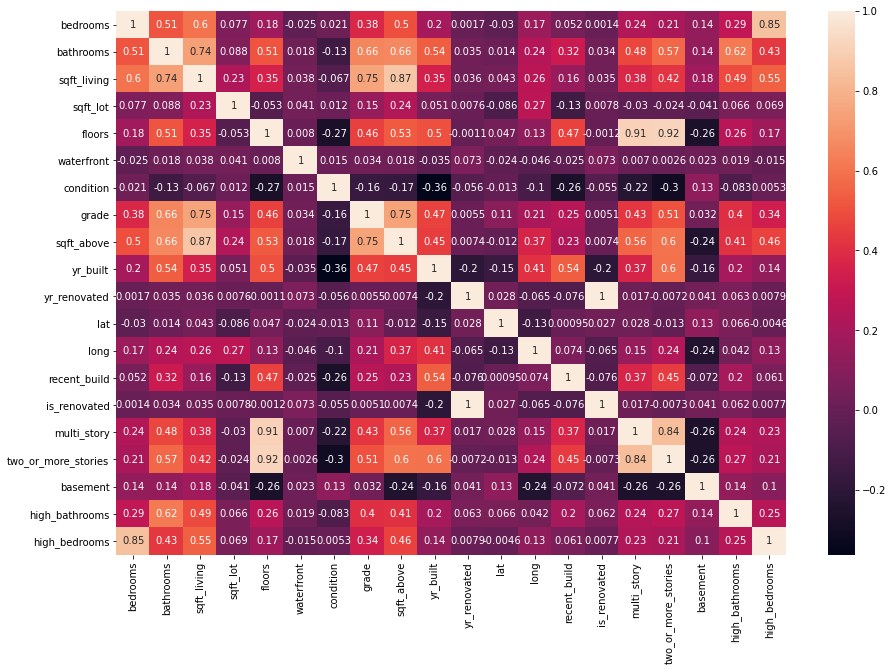

In [45]:
fig, ax = plt.subplots(figsize=(15,10))

sns.heatmap(X_multi_coll.corr(), annot=True, ax=ax)
plt.show()

# Seems like some of the metrics related to size may be correlated

In [46]:
# Filter for only multicollinearity above a certain threshold

mult_corr = X_multi_coll.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
mult_corr['pairs'] = list(zip(mult_corr.level_0, mult_corr.level_1))

# set index to pairs
mult_corr.set_index(['pairs'], inplace = True)

#d rop level columns
mult_corr.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
mult_corr.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
mult_corr.drop_duplicates(inplace=True)

mult_corr[(mult_corr.cc>.6)] #& (test.cc <1)]

# Conclusions: sqft_living_log is highly correlated with a number of other features.

,cc
pairs,
"(bedrooms, bedrooms)",1.000000
"(yr_renovated, is_renovated)",0.999967
"(two_or_more_stories, floors)",0.915495
"(floors, multi_story)",0.905038
"(sqft_above, sqft_living)",0.866974
"(high_bedrooms, bedrooms)",0.848540
"(two_or_more_stories, multi_story)",0.837660
"(grade, sqft_living)",0.752358
"(sqft_above, grade)",0.745242


### Log scale of variables

In [47]:
sales_clean['sqft_living_log'] = np.log(sales_clean['sqft_living'])
sales_clean['price_log'] = np.log(sales_clean['price'])

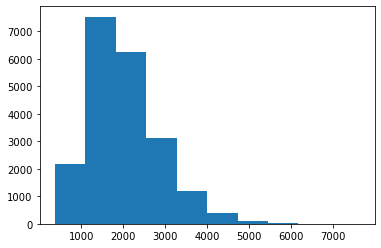

In [48]:
plt.hist(sales_clean['sqft_living']);

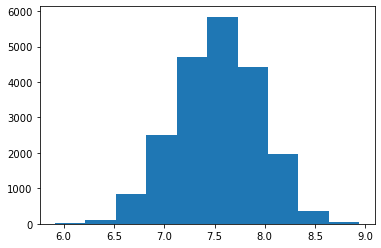

In [49]:
plt.hist(sales_clean['sqft_living_log']);

### Standardize variables

In [50]:
# TBD

## Modeling

Describe and justify the process for analyzing or modeling the data.

Questions to consider:

- How did you analyze the data to arrive at an initial approach?
- How did you iterate on your initial approach to make it better?
- Why are these choices appropriate given the data and the business problem?

In [51]:
# Create the train and test datasets
from sklearn.model_selection import train_test_split

y = sales_clean['price']
X = sales_clean.drop(columns=['id','price'], axis=1)

# Split the data out, specifying size of the split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.20,
                                                    random_state=5
)

# Merge back together into one Train and Test dataset
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

In [52]:
# Filter for only multicollinearity above a certain threshold

mult_corr = X_train.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
mult_corr['pairs'] = list(zip(mult_corr.level_0, mult_corr.level_1))

# set index to pairs
mult_corr.set_index(['pairs'], inplace = True)

#d rop level columns
mult_corr.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
mult_corr.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
mult_corr.drop_duplicates(inplace=True)

highly_corr = mult_corr[(mult_corr.cc>.6)] #& (test.cc <1)]

# Conclusions: sqft_living_log is highly correlated with a number of other features.

## Evaluation

The evaluation of each model should accompany the creation of each model, and you should be sure to evaluate your models consistently.

Evaluate how well your work solves the stated business problem. 

Questions to consider:

- How do you interpret the results?
- How well does your model fit your data? How much better is this than your baseline model? Is it over or under fit?
- How well does your model/data fit any modeling assumptions?

For the final model, you might also consider:

- How confident are you that your results would generalize beyond the data you have?
- How confident are you that this model would benefit the business if put into use?

### Baseline Understanding

- What does a baseline, model-less prediction look like?

In [53]:
# Linear reegression imports

from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
import sklearn.metrics as metrics

In [54]:
train_target_mean = y_train.mean()

In [55]:
baseline_train_preds = [train_target_mean] * len(y_train)
baseline_test_preds = [train_target_mean] * len(y_test)

In [56]:
# R squared
print('Model fit for training data')
print(f"R2: {metrics.r2_score(y_train, baseline_train_preds):.2f}")
# Mean squared error
print(f"MSE: {metrics.mean_squared_error(y_train, baseline_train_preds, squared=False):,.0f}")
# Mean absolute error
print(f"MAE: {metrics.mean_absolute_error(y_train, baseline_train_preds):,.0f}")
print("\n")

# R squared
print('Model fit for test data')
print(f"R2: {metrics.r2_score(y_test, baseline_test_preds):.2f}")
# Mean squared error
print(f"MSE: {metrics.mean_squared_error(y_test, baseline_test_preds, squared=False):,.0f}")
# Mean absolute error
print(f"MAE: {metrics.mean_absolute_error(y_test, baseline_test_preds):,.0f}")


Model fit for training data
R2: 0.00
MSE: 285,232
MAE: 208,519


Model fit for test data
R2: -0.00
MSE: 281,807
MAE: 206,444


### Simple model

First model will test price vs. its most correlated feature

In [57]:
df_train.corr().price.sort_values(ascending=False)

price              1.000000
price_log          0.940957
grade              0.678168
sqft_living        0.677795
sqft_living_log    0.627079
                     ...   
Tukwila           -0.109131
Lakeland_North    -0.110368
Covington         -0.117429
Auburn            -0.128523
Federal_Way       -0.157372
Name: price, Length: 64, dtype: float64

Train R2: 0.459
Test R2: 0.451
****
Train RMSE: 209,717
Test RMSE: 208,858
****
Train MAE: 153,771
Test MAE: 153,878

Residual scatter plot:


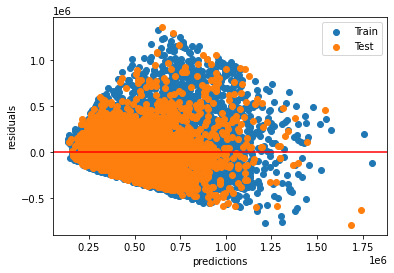



Residual qq plot


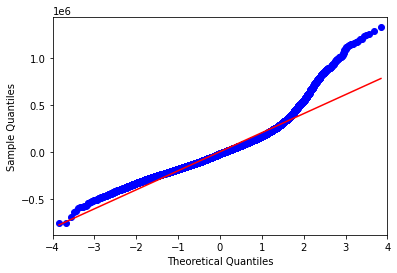

In [58]:
evaluate_model(df_train, df_test, ['sqft_living'], False)

## Modeling Iterations

Now you can start to use the results of your first model to iterate - there are many options!

In [59]:
# Recursive feature selection

lr_rfe = LinearRegression()
select = RFE(lr_rfe, n_features_to_select=5)

ss = StandardScaler()
ss.fit(df_train.drop(columns=['price','date', 'sqft_basement', 'neighborhood'], axis=1))

train_scaled = ss.transform(df_train.drop(columns=['price','date', 'sqft_basement', 'neighborhood'], axis=1))

select.fit(X=train_scaled, y=df_train['price'])

select.support_

select.ranking_

array([48, 54, 37, 46, 52, 42, 40, 59, 41, 50, 43, 35, 39, 45, 49, 53, 58,
       57, 36, 56, 51, 55, 44, 47, 32,  2, 12,  1,  5, 10, 28,  8, 25, 19,
        9, 27,  4, 26, 11, 21, 17,  1,  1, 14, 13,  1, 30,  7, 15, 29, 22,
       31,  1, 18, 20,  3, 24, 16, 23, 33,  6, 38, 34])

In [60]:
ranked = list(zip(select.ranking_,df_train.drop(columns=['price','date', 'sqft_basement', 'neighborhood'], axis=1).columns))

### Log transformation of living area square feet and price

Train R2: 0.418
Test R2: 0.412
****
Train RMSE: 217,665
Test RMSE: 216,061
****
Train MAE: 153,967
Test MAE: 153,829

Residual scatter plot:


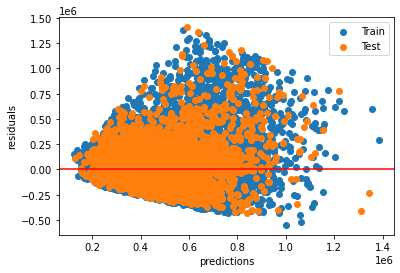



Residual qq plot


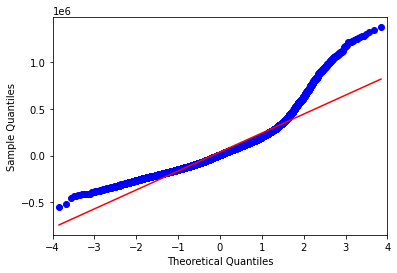

In [61]:
evaluate_model(df_train, df_test, ['sqft_living_log'], True)

### Various iterations of size

Train R2: 0.494
Test R2: 0.507
****
Train RMSE: 202,900
Test RMSE: 197,887
****
Train MAE: 142,683
Test MAE: 141,078

Residual scatter plot:


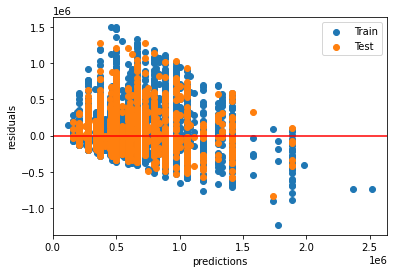



Residual qq plot


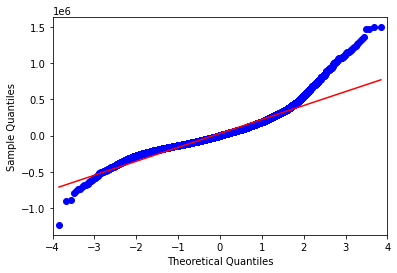

In [62]:
# Replace sqft_living_log with other versions of size

cols1 = ['high_bathrooms', 'grade', 'recent_build', 'is_renovated']

model_output1, train_preds1, test_preds1 = run_model(df_train, df_test, cols1, True)

evaluate_model(df_train, df_test, cols1, True)

In [63]:
highly_corr

,cc
pairs,
"(bedrooms, bedrooms)",1.000000
"(is_renovated, yr_renovated)",0.999967
"(sqft_living, sqft_living_log)",0.964524
"(floors, two_or_more_stories)",0.915228
"(multi_story, floors)",0.904618
"(sqft_living, sqft_above)",0.866050
"(high_bedrooms, bedrooms)",0.849174
"(two_or_more_stories, multi_story)",0.839500
"(sqft_above, sqft_living_log)",0.825211


Train R2: 0.500
Test R2: 0.514
****
Train RMSE: 201,665
Test RMSE: 196,367
****
Train MAE: 141,652
Test MAE: 140,137

Residual scatter plot:


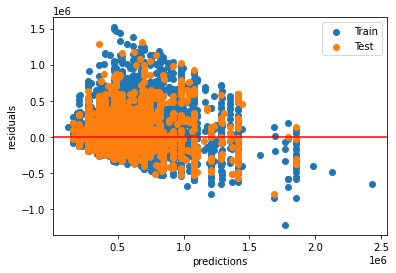



Residual qq plot


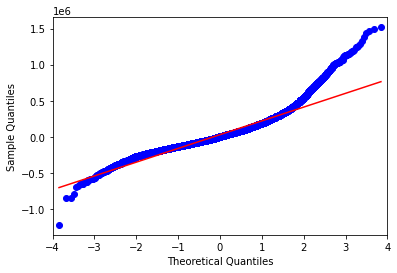

In [64]:
cols2 = ['high_bathrooms', 'high_bedrooms', 'multi_story', 'grade', 'recent_build', 'is_renovated']

model_output2, train_preds2, test_preds2 = run_model(df_train, df_test, cols2, True)

evaluate_model(df_train, df_test, cols2, True)

Train R2: 0.504
Test R2: 0.516
****
Train RMSE: 200,831
Test RMSE: 196,108
****
Train MAE: 141,007
Test MAE: 139,708

Residual scatter plot:


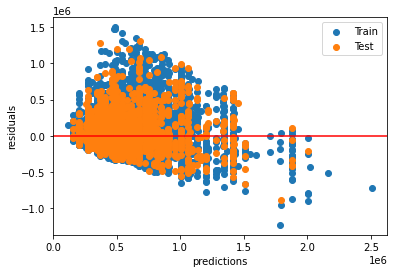



Residual qq plot


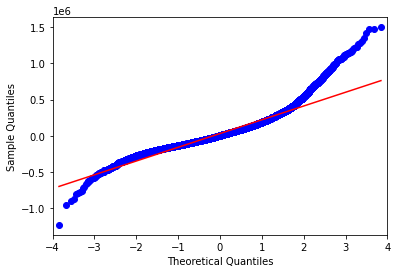

In [65]:
cols3 = ['high_bathrooms', 'high_bedrooms', 'two_or_more_stories', 'grade', 'recent_build', 'is_renovated']

model_output3, train_preds3, test_preds3 = run_model(df_train, df_test, cols3, True)

evaluate_model(df_train, df_test, cols3, True)

Train R2: 0.514
Test R2: 0.525
****
Train RMSE: 198,748
Test RMSE: 194,191
****
Train MAE: 138,881
Test MAE: 137,987

Residual scatter plot:


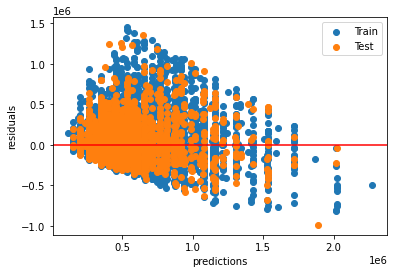



Residual qq plot


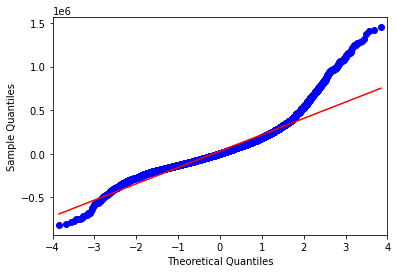

In [66]:
cols4 = ['high_bathrooms', 'high_bedrooms', 'two_or_more_stories', 'grade', 'recent_build', 'basement']

model_output4, train_preds4, test_preds4 = run_model(df_train, df_test, cols4, True)

evaluate_model(df_train, df_test, cols4, True)

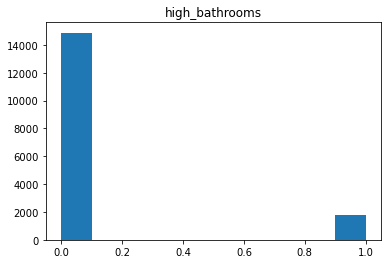

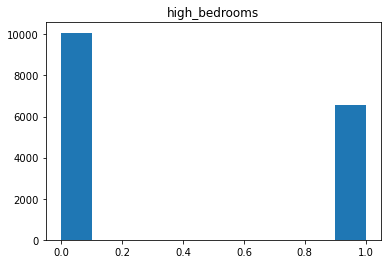

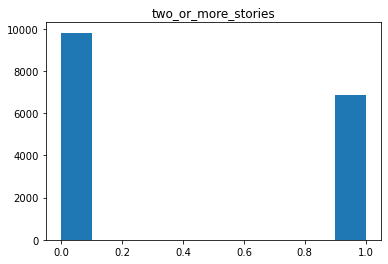

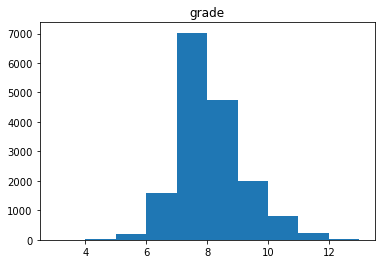

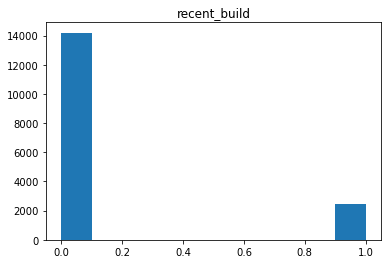

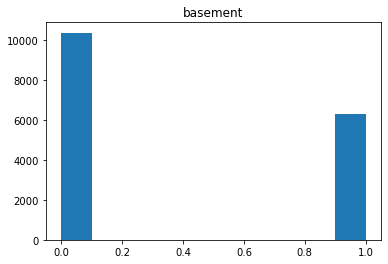

In [67]:
for col in cols4:
    plt.hist(df_train[col])
    plt.title(col)
    plt.show();

### Create interaction variables and use neighborhood

In [68]:
neighborhood_df = pd.DataFrame(df_train.groupby(by='neighborhood')['price'].agg(['mean', 'count']))

neighborhood_df['avg_price'] = df_train['price'].mean()
neighborhood_df['price_delta'] = abs(neighborhood_df['mean'] - neighborhood_df['avg_price'])

neighborhood_df.sort_values(by='price_delta')

# Comments: I'm choosing to remove Shorline as it has the best combination of largest and closest to mean

,mean,count,avg_price,price_delta
neighborhood,,,,
Snoqualmie,5.307298e+05,236,515917.484701,14812.303434
Shoreline,4.923370e+05,563,515917.484701,23580.513120
Bothell,4.892041e+05,155,515917.484701,26713.381475
Vashon,4.758891e+05,78,515917.484701,40028.433419
Seattle,5.593661e+05,5185,515917.484701,43448.609224
Fall_City,4.719235e+05,49,515917.484701,43994.015313
Kenmore,4.632268e+05,235,515917.484701,52690.676191
Woodinville,5.776108e+05,219,515917.484701,61693.305253
Issaquah,5.997643e+05,572,515917.484701,83846.833481


In [69]:
# Create new variable sqft vs lot size for the home and its neighbors

df_train['size_vs_lot'] = df_train['sqft_living'] / df_train['sqft_lot']
df_test['size_vs_lot'] = df_test['sqft_living'] / df_test['sqft_lot']
df_train['size_vs_lot_log'] = np.log(df_train['size_vs_lot'])
df_test['size_vs_lot_log'] = np.log(df_test['size_vs_lot'])


df_train['neighbor_size_vs_lot'] = df_train['sqft_living15'] / df_train['sqft_lot15']
df_test['neighbor_size_vs_lot'] = df_test['sqft_living15'] / df_test['sqft_lot15']

Train R2: 0.689
Test R2: 0.681
****
Train RMSE: 159,115
Test RMSE: 159,114
****
Train MAE: 102,071
Test MAE: 102,191

Residual scatter plot:


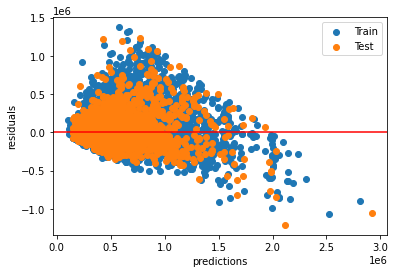



Residual qq plot


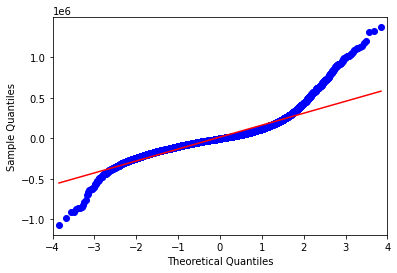

In [70]:
cols5 = ['high_bathrooms', 'high_bedrooms', 'two_or_more_stories', 'grade', 'recent_build', 'basement',
        'size_vs_lot'] + [x for x in neighborhood_list if x != 'Shoreline']

model_output5, train_preds5, test_preds5 = run_model(df_train, df_test, cols5, True)

evaluate_model(df_train, df_test, cols5, True)

In [71]:
# Create new variable for relative number of bathrooms vs. bedrooms

df_train['bath_vs_bed'] = df_train['bathrooms'] / df_train['bedrooms']
df_test['bath_vs_bed'] = df_test['bathrooms'] / df_test['bedrooms']

df_train['bath_vs_bed_log'] = np.log(df_train['bath_vs_bed'])
df_test['bath_vs_bed_log'] = np.log(df_test['bath_vs_bed'])

df_train['sqft_living15_log'] = np.log(df_train['sqft_living15'])
df_test['sqft_living15_log'] = np.log(df_test['sqft_living15'])

Train R2: 0.704
Test R2: 0.701
****
Train RMSE: 155,205
Test RMSE: 154,125
****
Train MAE: 97,355
Test MAE: 97,378

Residual scatter plot:


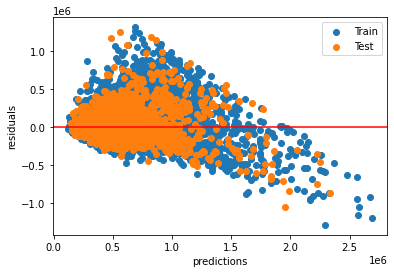



Residual qq plot


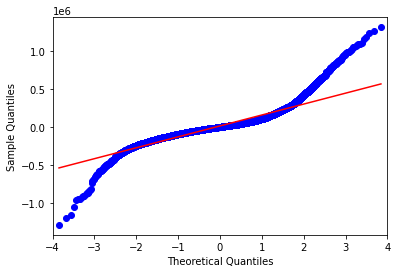

In [72]:
cols6 = cols5 + ['bath_vs_bed', 'sqft_living15']

model_output6, train_preds6, test_preds6 = run_model(df_train, df_test, cols6, True)

evaluate_model(df_train, df_test, cols6, True)

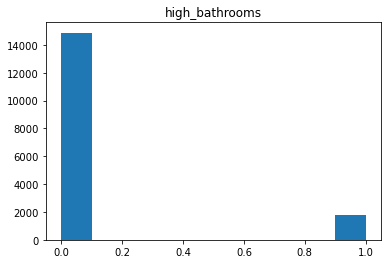

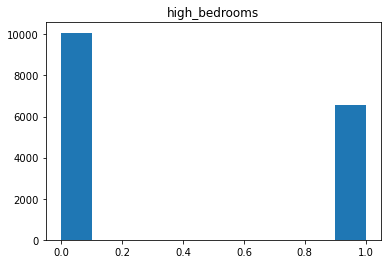

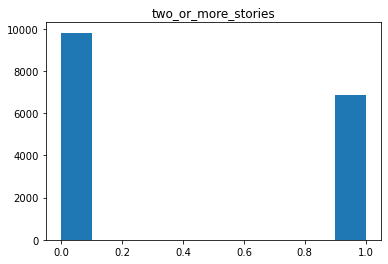

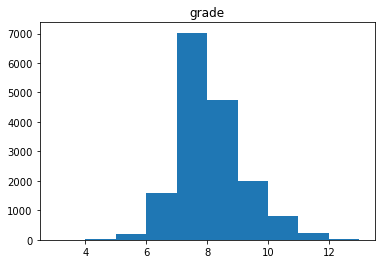

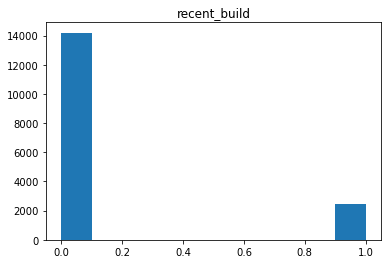

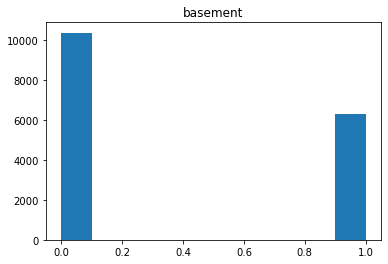

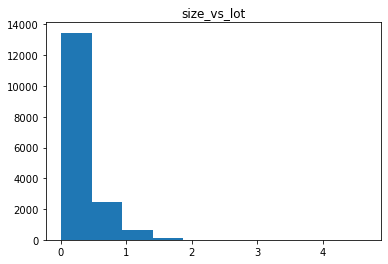

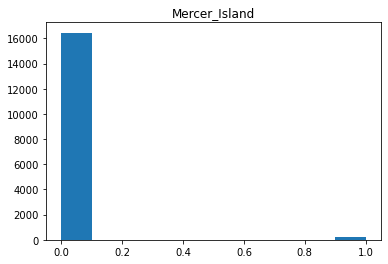

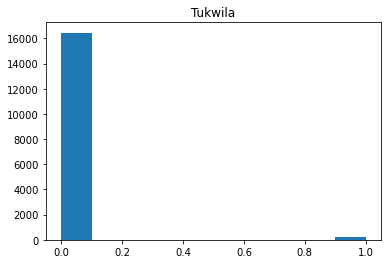

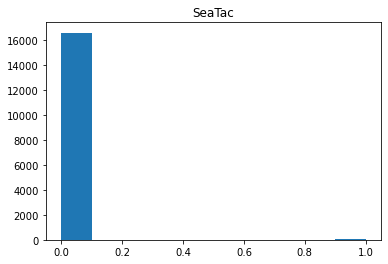

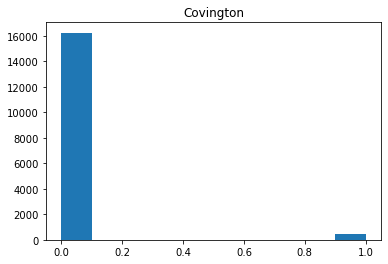

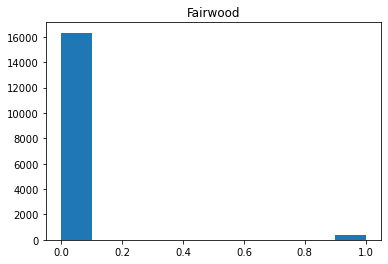

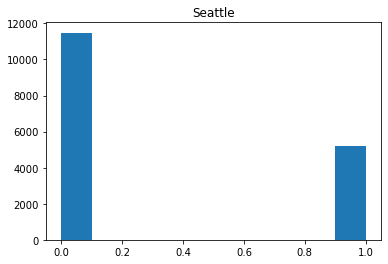

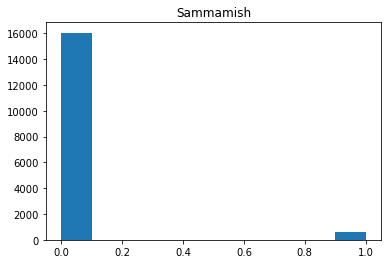

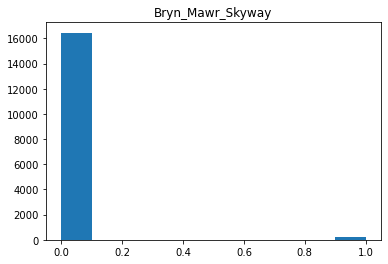

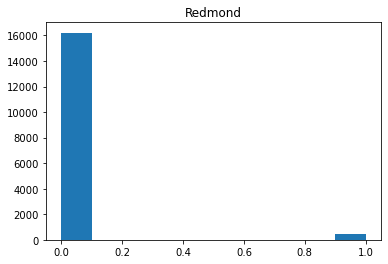

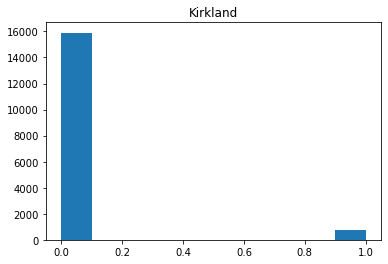

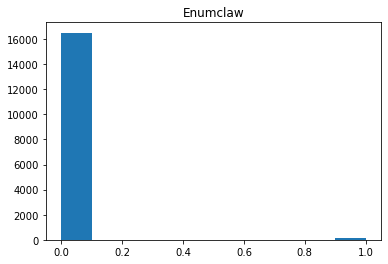

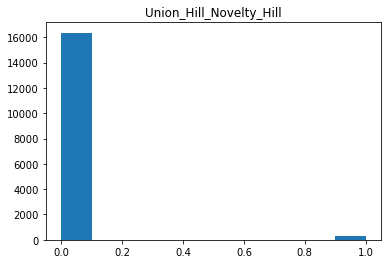

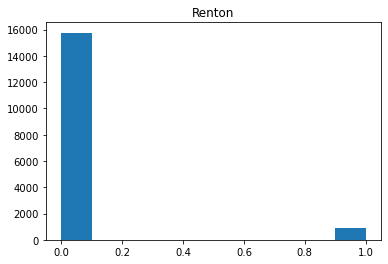

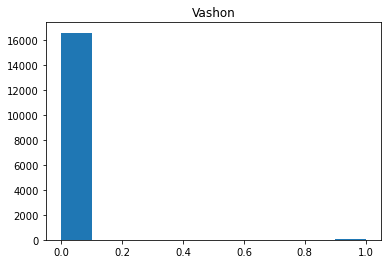

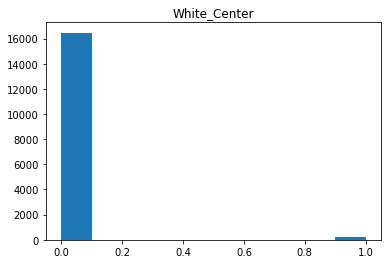

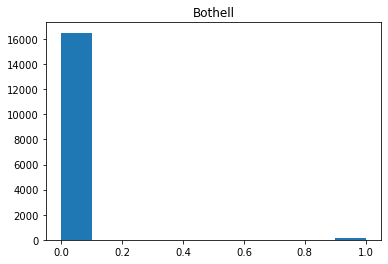

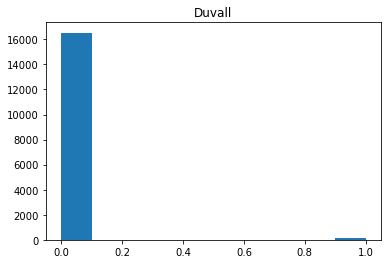

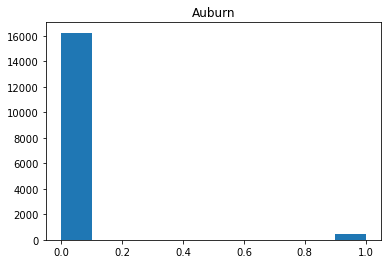

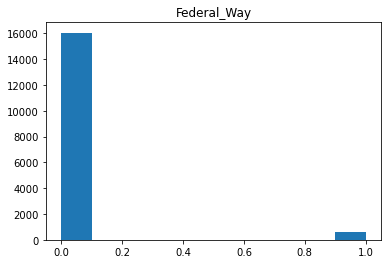

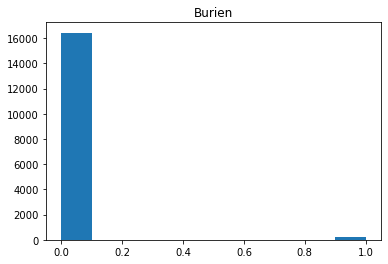

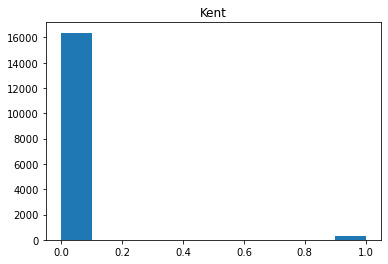

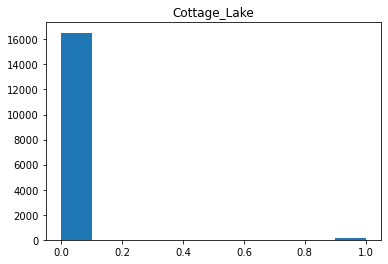

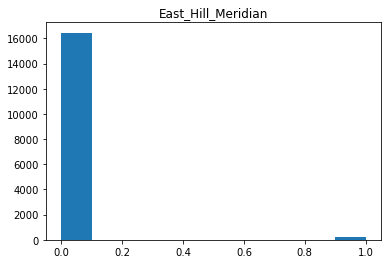

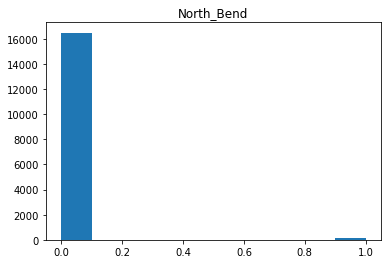

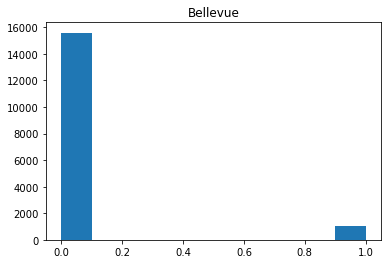

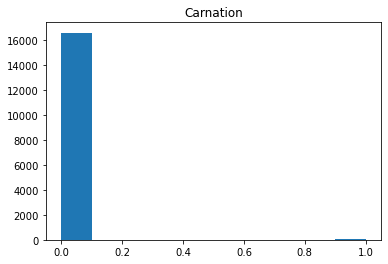

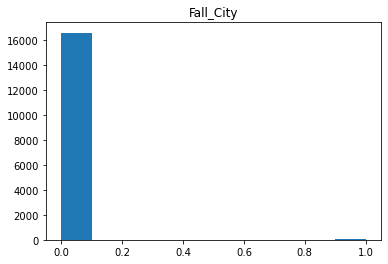

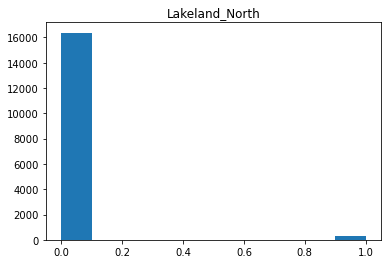

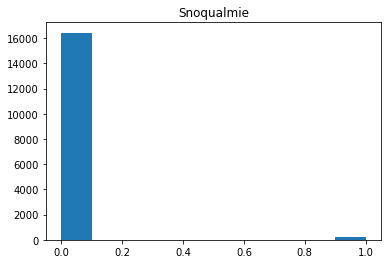

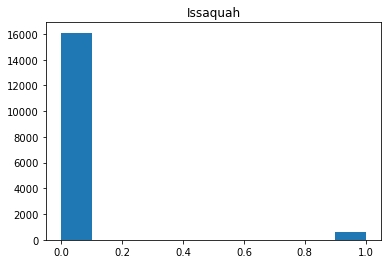

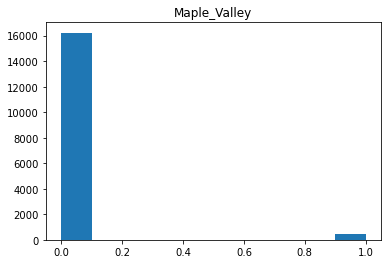

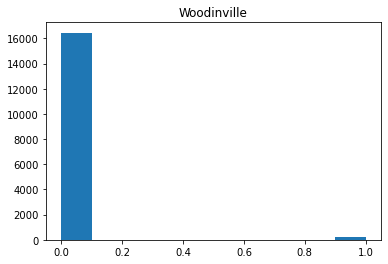

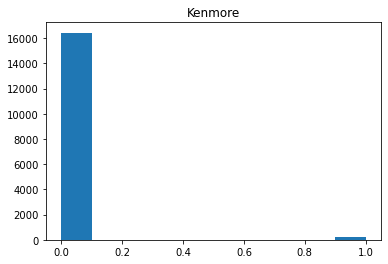

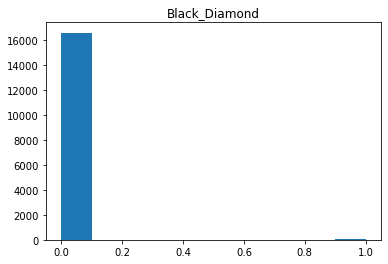

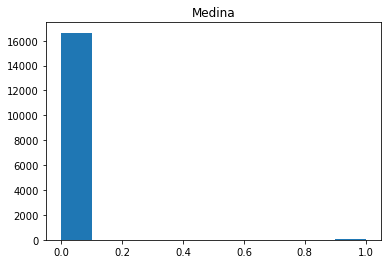

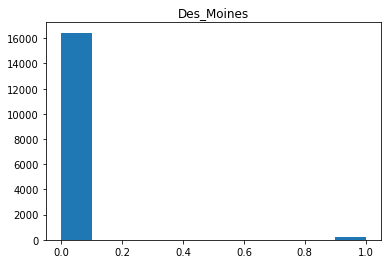

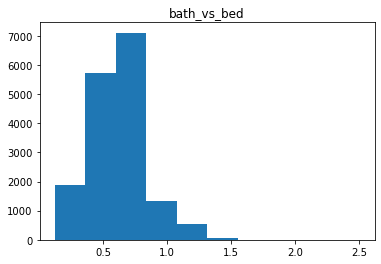

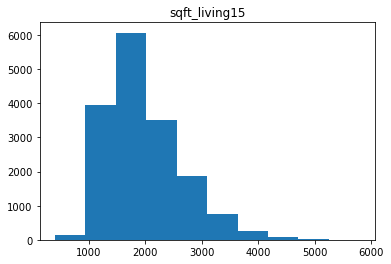

In [73]:
for col in cols6:
    plt.hist(df_train[col])
    plt.title(col)
    plt.show();
    
# There's a normality issue with a few of the independent variables

In [74]:
df_train.columns

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'recent_build', 'is_renovated',
       'multi_story', 'two_or_more_stories', 'basement', 'high_bathrooms',
       'high_bedrooms', 'neighborhood', 'Mercer_Island', 'Tukwila', 'SeaTac',
       'Covington', 'Fairwood', 'Seattle', 'Sammamish', 'Bryn_Mawr_Skyway',
       'Redmond', 'Kirkland', 'Enumclaw', 'Union_Hill_Novelty_Hill', 'Renton',
       'Vashon', 'White_Center', 'Bothell', 'Duvall', 'Auburn', 'Federal_Way',
       'Burien', 'Shoreline', 'Kent', 'Cottage_Lake', 'East_Hill_Meridian',
       'North_Bend', 'Bellevue', 'Carnation', 'Fall_City', 'Lakeland_North',
       'Snoqualmie', 'Issaquah', 'Maple_Valley', 'Woodinville', 'Kenmore',
       'Black_Diamond', 'Medina', 'Des_Moines', 'sqft_living_log', 'price_log',
       'price',

Train R2: 0.723
Test R2: 0.721
****
Train RMSE: 150,170
Test RMSE: 148,904
****
Train MAE: 95,302
Test MAE: 94,773

Residual scatter plot:


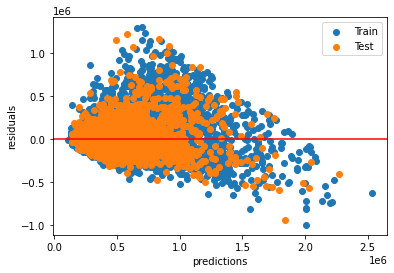



Residual qq plot


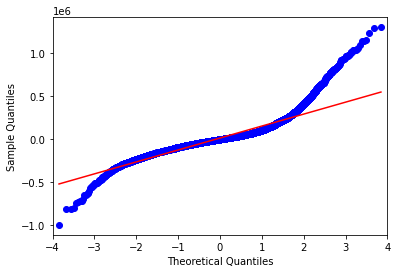

In [75]:
# Use latest col6 but replace with log values
cols7 = ['high_bathrooms', 'high_bedrooms', 'two_or_more_stories', 'grade', 'recent_build', 'basement',
        'size_vs_lot_log', 'bath_vs_bed_log', 'sqft_living15_log'] + [x for x in neighborhood_list if x != 'Shoreline']

model_output7, train_preds7, test_preds7 = run_model(df_train, df_test, cols7, True)

evaluate_model(df_train, df_test, cols7, True)

In [85]:
cols7

['high_bathrooms',
 'high_bedrooms',
 'two_or_more_stories',
 'grade',
 'recent_build',
 'basement',
 'size_vs_lot_log',
 'bath_vs_bed_log',
 'sqft_living15_log',
 'Mercer_Island',
 'Tukwila',
 'SeaTac',
 'Covington',
 'Fairwood',
 'Seattle',
 'Sammamish',
 'Bryn_Mawr_Skyway',
 'Redmond',
 'Kirkland',
 'Enumclaw',
 'Union_Hill_Novelty_Hill',
 'Renton',
 'Vashon',
 'White_Center',
 'Bothell',
 'Duvall',
 'Auburn',
 'Federal_Way',
 'Burien',
 'Kent',
 'Cottage_Lake',
 'East_Hill_Meridian',
 'North_Bend',
 'Bellevue',
 'Carnation',
 'Fall_City',
 'Lakeland_North',
 'Snoqualmie',
 'Issaquah',
 'Maple_Valley',
 'Woodinville',
 'Kenmore',
 'Black_Diamond',
 'Medina',
 'Des_Moines']

In [82]:
testing = df_train[cols7]

high_corr_values = high_corr(testing, 0.5)

In [83]:
high_corr_values

,cc
pairs,
"(high_bathrooms, high_bathrooms)",1.000000
"(sqft_living15_log, grade)",0.680637
"(grade, two_or_more_stories)",0.505913


In [84]:
df_train.columns

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'recent_build', 'is_renovated',
       'multi_story', 'two_or_more_stories', 'basement', 'high_bathrooms',
       'high_bedrooms', 'neighborhood', 'Mercer_Island', 'Tukwila', 'SeaTac',
       'Covington', 'Fairwood', 'Seattle', 'Sammamish', 'Bryn_Mawr_Skyway',
       'Redmond', 'Kirkland', 'Enumclaw', 'Union_Hill_Novelty_Hill', 'Renton',
       'Vashon', 'White_Center', 'Bothell', 'Duvall', 'Auburn', 'Federal_Way',
       'Burien', 'Shoreline', 'Kent', 'Cottage_Lake', 'East_Hill_Meridian',
       'North_Bend', 'Bellevue', 'Carnation', 'Fall_City', 'Lakeland_North',
       'Snoqualmie', 'Issaquah', 'Maple_Valley', 'Woodinville', 'Kenmore',
       'Black_Diamond', 'Medina', 'Des_Moines', 'sqft_living_log', 'price_log',
       'price',

In [77]:
# code here to evaluate your iterations

### 'Final' Model

In the end, you'll arrive at a 'final' model - aka the one you'll use to make your recommendations/conclusions. This likely blends any group work. It might not be the one with the highest scores, but instead might be considered 'final' or 'best' for other reasons.

In [78]:
# code here to show your final model

In [79]:
# code here to evaluate your final model

## Conclusions

Provide your conclusions about the work you've done, including any limitations or next steps.

Questions to consider:

- What would you recommend the business do as a result of this work?
- What are some reasons why your analysis might not fully solve the business problem?
- What else could you do in the future to improve this project (future work)?


In [80]:
# Code for visualization location vs. price

# Import
# import plotly.express as px

# # Explore relationship between location and price
# fig = px.scatter_mapbox(data_frame = train_df, # df name
#                         lat='lat', # name of latitude column
#                         lon='long', # name of longitude column
#                         color='price', # name of column to use for the color
#                         zoom=8)
# fig.update_layout(mapbox_style="open-street-map")
# fig.show()